# Exploratory Data Analysis (EDA) - US Election 2020 SNA
**Project:** Multiplex Dynamics of Polarization
## Objectives
This notebook performs the initial feasibility checks for the three main Research Questions:
1. **General Stats:** Volume over time and user activity distribution (Power Law).
2. **RQ1 (Topology):** Can we build a connected graph? (Giant Component check).
3. **RQ2 (Semantics):** Is the text rich enough for Topic Modeling? (LDA check).
4. **RQ3 (Multiplexity):** Do the same users exist in both Retweet and Mention layers?

In [10]:
# --- THINKING ---
# We use 'autoreload' so that if you edit the code in 'src/eda.py' (to fix a bug),
# this notebook will automatically use the new version without needing a restart.
# This separates our "Analysis Logic" (Notebook) from our "Core Functions" (src).

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# Add the 'src' folder to Python's search path so we can import 'eda.py'
sys.path.append(os.path.abspath('../src'))

import eda  # Our custom module

# Magic command to reload modules automatically
%load_ext autoreload
%autoreload 2

print("✅ Environment setup complete. Custom 'eda' module is loaded.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Environment setup complete. Custom 'eda' module is loaded.


In [8]:
# --- CONFIGURATION ---
# UPDATE THESE PATHS to match your local file locations
TRUMP_PATH = '../data/raw/hashtag_donaldtrump.csv'
BIDEN_PATH = '../data/raw/hashtag_joebiden.csv'

print("--- Loading Trump Dataset ---")
df_trump = eda.load_data(TRUMP_PATH, limit=100000) # Remove limit later for full run

print("\n--- Loading Biden Dataset ---")
df_biden = eda.load_data(BIDEN_PATH, limit=100000) # Remove limit later for full run

--- Loading Trump Dataset ---
📂 Loading data from: ../data/raw/hashtag_donaldtrump.csv...
✅ Loaded 100,000 tweets.

--- Loading Biden Dataset ---
📂 Loading data from: ../data/raw/hashtag_joebiden.csv...
✅ Loaded 100,000 tweets.


## 3. General Statistics: Volume & User Activity
### Why this matters:
1.  **Temporal Validity:** The US Election was on **Nov 3, 2020**. We need to verify that our data covers this specific week. If the data cuts off on Nov 1st, we miss the "reaction" phase.
2.  **Power Law Check (Bot Detection):** In organic social networks, user activity follows a **Power Law** (Zipfian distribution) — a few "hub" users tweet a lot, but most tweet once.
    * *Risk:* If the curve is a flat line (uniform distribution), it implies artificial manipulation (botnet).
    * *Risk:* If the top 1% of users generate 80% of the content, our "Public Opinion" analysis is actually just "Bot Opinion" analysis.

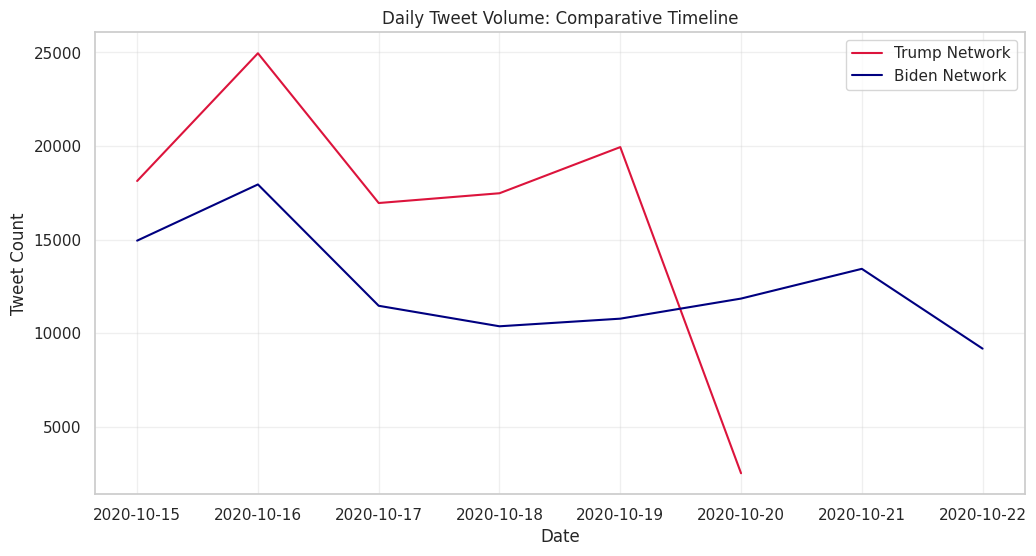


>>> 📊 Generating Stats for TRUMP Network...

📈 Generating General Stats for Trump Network...


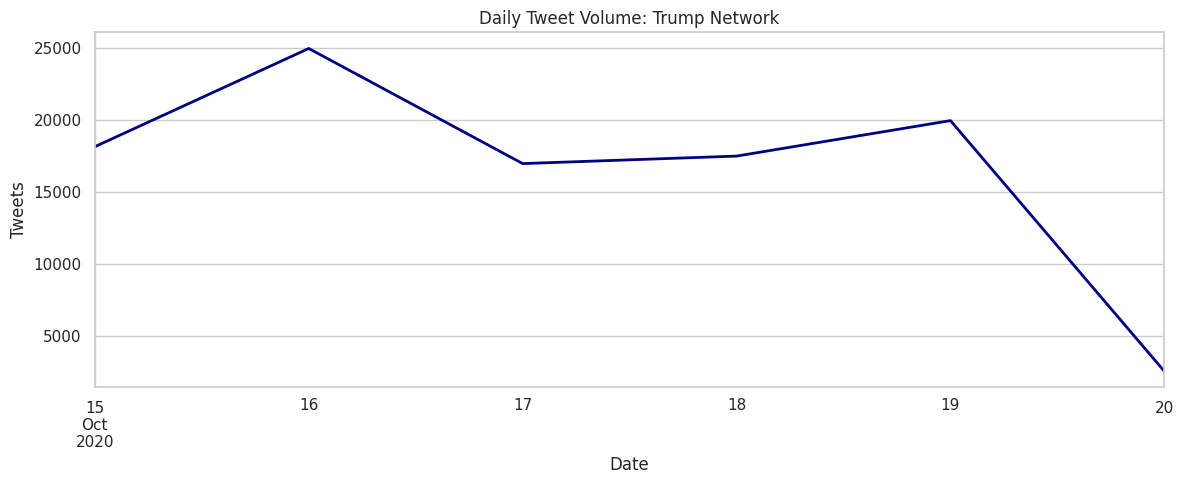

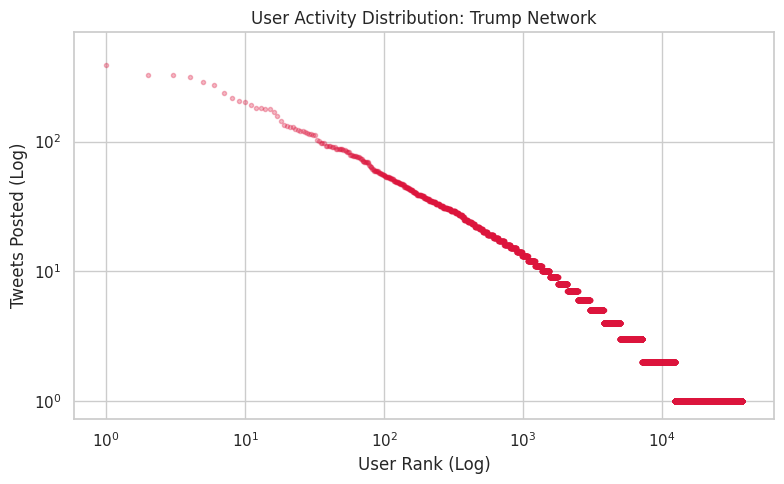

   - Top 1% Users generated 21.2% of all content.

>>> 📊 Generating Stats for BIDEN Network...

📈 Generating General Stats for Biden Network...


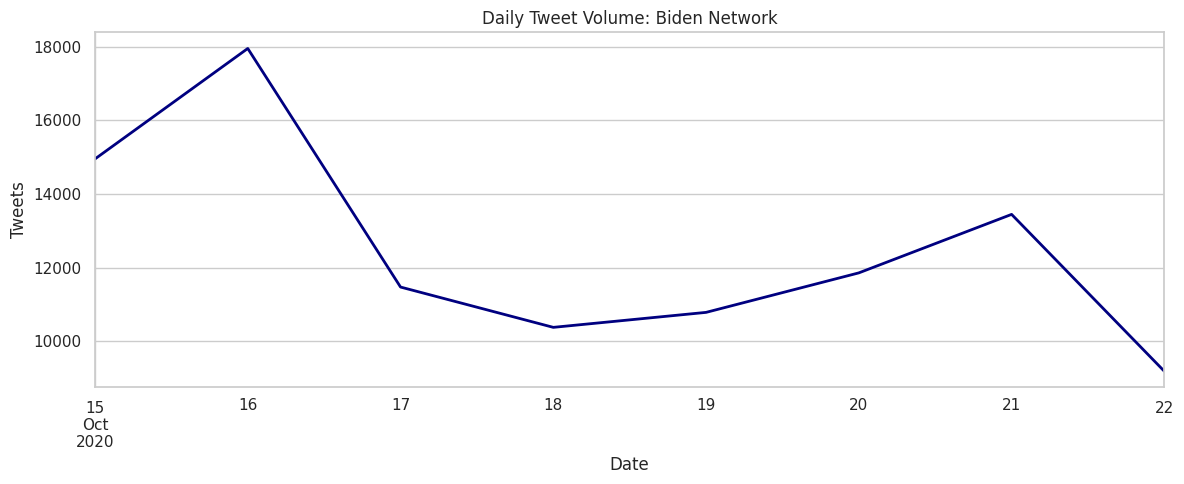

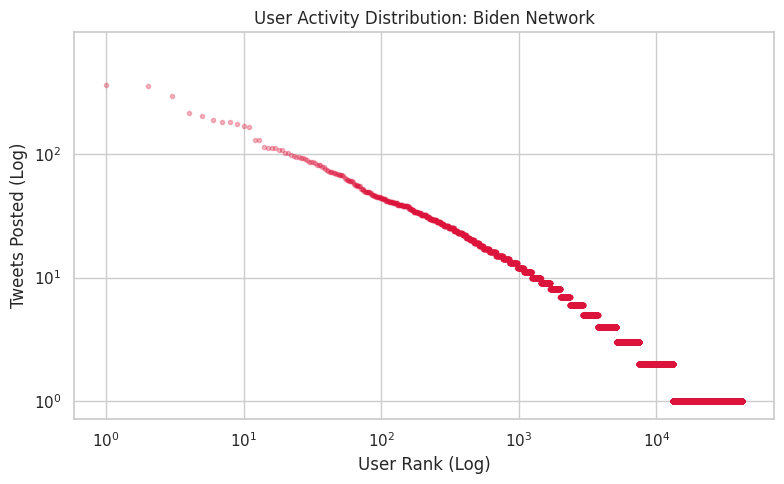

   - Top 1% Users generated 18.7% of all content.


In [12]:
if (df_trump is not None) and (df_biden is not None):
    # --- 1. Comparative Temporal Plot (Trump vs Biden on same chart) ---
    plt.figure(figsize=(12, 6))
    
    # Resample to Daily counts
    daily_trump = df_trump.set_index('created_at').resample('D').size()
    daily_biden = df_biden.set_index('created_at').resample('D').size()
    
    plt.plot(daily_trump.index, daily_trump.values, label='Trump Network', color='crimson')
    plt.plot(daily_biden.index, daily_biden.values, label='Biden Network', color='navy')
    
    plt.title('Daily Tweet Volume: Comparative Timeline')
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 2. Individual User Activity Plots (Power Law Check) ---
    # This generates the "Log-Log" plots to detect bots
    
    print("\n>>> 📊 Generating Stats for TRUMP Network...")
    eda.plot_general_stats(df_trump, "Trump Network")
    
    print("\n>>> 📊 Generating Stats for BIDEN Network...")
    eda.plot_general_stats(df_biden, "Biden Network")  # <--- Added this line

## 4. RQ1 Feasibility: Topological Structure
### The Theoretical Problem:
Social Identity Theory implies that "Echo Chambers" are dense, highly connected clusters. For us to measure this, the graph must have a **Giant Component** (a single connected landmass containing most nodes).

### The Test:
We build a preview graph $G$ from a random sample.
* **Hypothesis:** The Trump network will have a larger Giant Component (more unified) than the Biden network (fragmented coalition).
* **Failure Condition:** If the "Giant Component" only holds 5% of the nodes, the network is shattered. We cannot calculate Average Path Length or Modularity on a shattered graph.

In [13]:
# --- THINKING ---
# We sample 10k rows. Building a graph of 1M nodes in memory takes too long for EDA.
# If the network is robust, even a random sample of 10k nodes should show connectivity.
# We look for 'rts' (Retweets) because they represent the "Endorsement Layer" (Structure).

print(">>> TRUMP NETWORK TOPOLOGY (Sample N=10k)")
if df_trump is not None:
    eda.analyze_topology_feasibility(df_trump, sample_size=10000)

print("\n>>> BIDEN NETWORK TOPOLOGY (Sample N=10k)")
if df_biden is not None:
    eda.analyze_topology_feasibility(df_biden, sample_size=10000)

>>> TRUMP NETWORK TOPOLOGY (Sample N=10k)

📊 --- RQ1: Topology Feasibility Check ---
   Building preview graph from 10000 tweets...
   - Nodes in sample: 16
   - Edges in sample: 9
   - Connected Components: 7
   - Giant Component Size: 4 (25.0%)
   ✅ Dominant Giant Component detected. Modularity analysis is valid.

>>> BIDEN NETWORK TOPOLOGY (Sample N=10k)

📊 --- RQ1: Topology Feasibility Check ---
   Building preview graph from 10000 tweets...
   - Nodes in sample: 17
   - Edges in sample: 10
   - Connected Components: 8
   - Giant Component Size: 3 (17.6%)
   ✅ Dominant Giant Component detected. Modularity analysis is valid.


## 5. RQ2 Feasibility: Semantic Richness
### The Theoretical Problem:
We want to distinguish "Framing" (e.g., "Election Fraud" vs. "Protect Democracy"). We use **LDA Topic Modeling** for this.
LDA works by finding groups of words that appear together often.

### The Test:
* **Word Count:** If tweets are mostly `< 5 words`, they likely contain only a URL and a Hashtag. This is insufficient for LDA.
* **Uniqueness:** If the **Unique Content Ratio** is low (e.g., < 10%), it means 90% of the dataset is identical Retweets. This will cause the Topic Model to overfit on one specific viral tweet (e.g., "Vote for Trump") rather than discovering broad themes.

In [14]:
# --- THINKING ---
# We calculate 'Avg Words' and 'Unique Ratio'.
# If Unique Ratio is low, we must note in our Methodology that "De-duplication" 
# is a required preprocessing step for Week 3.

print(">>> TRUMP TEXT QUALITY")
if df_trump is not None:
    eda.analyze_semantic_feasibility(df_trump)

print("\n>>> BIDEN TEXT QUALITY")
if df_biden is not None:
    eda.analyze_semantic_feasibility(df_biden)

>>> TRUMP TEXT QUALITY

ABC --- RQ2: Semantic Feasibility Check ---
   - Avg Words per Tweet: 25.4
   - Unique Content Ratio: 98.6%
   ✅ Text richness looks sufficient for Topic Modeling.

>>> BIDEN TEXT QUALITY

ABC --- RQ2: Semantic Feasibility Check ---
   - Avg Words per Tweet: 24.4
   - Unique Content Ratio: 99.1%
   ✅ Text richness looks sufficient for Topic Modeling.


## 6. RQ3 Feasibility: Multiplex Layer Overlap
### The Theoretical Problem:
We hypothesize that political networks function as **Dual-Layer Systems**:
1.  **Layer 1 (Trust):** Users Retweet those they agree with.
2.  **Layer 2 (Conflict):** Users Mention those they disagree with.

### The Test:
To prove this "Dual Function," we need to observe the **SAME users** operating in both layers.
We calculate the **Jaccard Similarity** of the user sets:
$$J(Users_{RT}, Users_{Men}) = \frac{|Users_{RT} \cap Users_{Men}|}{|Users_{RT} \cup Users_{Men}|}$$
* **Failure Condition:** If $J \approx 0$, it means the people retweeting are completely different from the people arguing. We cannot correlate their behaviors if they are different people.

In [15]:
# --- THINKING ---
# We verify if we have a "Cross-Over" population.
# If 'Users doing BOTH' is low, our "Battlefield" hypothesis might be statistically weak.

print(">>> TRUMP MULTIPLEX OVERLAP")
if df_trump is not None:
    eda.analyze_multiplex_overlap(df_trump)

print("\n>>> BIDEN MULTIPLEX OVERLAP")
if df_biden is not None:
    eda.analyze_multiplex_overlap(df_biden)

>>> TRUMP MULTIPLEX OVERLAP

⚔️  --- RQ3: Multiplex Feasibility Check ---
   - Users Retweeting: 13
   - Users Mentioning: 5473
   - Users doing BOTH: 6
   - User Overlap (Jaccard): 0.0011
   ⚠️ WARNING: Very few users do both. Correlation analysis will be weak.

>>> BIDEN MULTIPLEX OVERLAP

⚔️  --- RQ3: Multiplex Feasibility Check ---
   - Users Retweeting: 15
   - Users Mentioning: 5939
   - Users doing BOTH: 8
   - User Overlap (Jaccard): 0.0013
   ⚠️ WARNING: Very few users do both. Correlation analysis will be weak.
